<a href="https://colab.research.google.com/github/thaovivng/SMSSpamDetection/blob/main/NLP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tải dữ liệu và thư viện

In [1]:
#Tải thư viện
!pip install unidecode
!pip install contractions
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.8 MB/s eta 0:00:00


In [2]:
## Thư viện
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import contractions
import unicodedata
import unidecode
import time

from wordcloud import WordCloud

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.classify import MaxentClassifier
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.metrics import auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization, Dropout, Dense

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Đọc file

In [3]:
# Load file dữ liệu từ link https://drive.google.com/file/d/1gs9Dvdx_SxyQY4OfFPG4NF22UYjt6e-F/view?usp=drive_link
!gdown 1gs9Dvdx_SxyQY4OfFPG4NF22UYjt6e-F

Downloading...
From: https://drive.google.com/uc?id=1gs9Dvdx_SxyQY4OfFPG4NF22UYjt6e-F
To: /content/spam.csv
100% 504k/504k [00:00<00:00, 81.9MB/s]


In [4]:
#Đọc file
import chardet

with open('spam.csv', 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv('spam.csv', encoding=result['encoding'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#1. Tiền xử lý

##Kiểm tra và xử lý giá trị trùng lặp

In [7]:
# Kiểm tra giá trị trùng lặp
df.duplicated().sum()

403

In [8]:
# Loại bỏ giá trị trùng lặp
df = df.drop_duplicates(keep = 'first')

##Missing data

In [9]:
# Tính phần trăm giá trị null cho từng cột
null_percentages = (df.isnull().mean() * 100).round(2)

# Hiển thị kết quả
print(null_percentages)

v1             0.00
v2             0.00
Unnamed: 2    99.17
Unnamed: 3    99.81
Unnamed: 4    99.90
dtype: float64


In [10]:
#Drop các cột có trên 90% giá trị null
# Loại bỏ cột 'Unnamed: 2, Unnamed: 3, Unnamed: 4'
df = df.drop('Unnamed: 2', axis=1, errors='ignore')
df = df.drop('Unnamed: 3', axis=1, errors='ignore')
df = df.drop('Unnamed: 4', axis=1, errors='ignore')
# Kiểm tra lại tên cột sau khi loại bỏ
print(df.columns)

Index(['v1', 'v2'], dtype='object')


In [11]:
# Đặt lại tên cột
df.columns = ['target', 'message']

In [12]:
# Thêm cột để đếm số từ trong mỗi dòng
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


## Xử lý văn bản

In [13]:
# Tạo danh sách các stopword hoàn thiện
stop_words = stopwords.words('english')
more_stopwords = ['u','ur', 'i\'m', 'c','ill','ive','dnt','dont','dun','bcoz','n']
stop_words = stop_words + more_stopwords

abbreviations = []
new_words = []
for word in stop_words:
  if "'" in word:
    abbreviations.append(word)
for word in abbreviations:
    new_word = re.sub("'","",word)
    new_words.append(new_word)
for word in new_words:
  if word not in stop_words:
    stop_words.append(word)

# Hàm xóa bỏ stopword
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

# Hàm lemmatization
def lemmatize_words(text):
    words = word_tokenize(text)
    lemma = WordNetLemmatizer()
    lemma_words = [lemma.lemmatize(word) for word in words]
    lemma_text = ' '.join(lemma_words)
    return lemma_text

# Hàm làm sạch dữ liệu
def clean_text(text):
    #Chuyển về chữ thường
    text = str(text).lower()

    #Loại bỏ nội dung trong dấu ngoặc vuông
    text = re.sub('\[.*?\]', '', text)

    #Loại bỏ nội dung trong dấu ngoặc tròn
    text = re.sub('\(.*?\)', '', text)

    #Loại bỏ đường dẫn web
    text = re.sub('https?://\S+|www\.\S+', '', text)

    #Loại bỏ thẻ HTML
    text = re.sub('<.*?>', '', text)

    # Biến kiểu viết tắt thành kiểu viết đầy đủ
    text = contractions.fix(text)

    # Xử lý các từ có dấu
    text = unidecode.unidecode(text)

    #Loại bỏ các dấu câu
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Loại bỏ stopwords
    text = remove_stopwords(text)

    #Loại bỏ các ký tự xuống dòng
    text = re.sub('\n', '', text)

    #Loại bỏ từ chứa chữ số
    text = re.sub('\w*\d\w*', '', text)

    #Loại bỏ các chuỗi chỉ chứa số
    text = re.sub(r'\b\d+\b','', text)

    #Loại bỏ các định dạng ngày tháng năm
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+','',text)

    #Loại bỏ bớt khoảng cách giữa các đoạn tin nhắn chứa nhiều hơn 2 khoảng cách giữa các từ
    text = re.sub(r' {2,}',' ',text)

    #lemmatization
    text = lemmatize_words(text)

    return text

df['message_clean'] = df['message'].apply(clean_text)

##Target Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis great wo...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts may...,1
3,ham,U dun say so early hor... U c already then say...,11,say early hor already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think go usf life around though,0


#2. Visualization

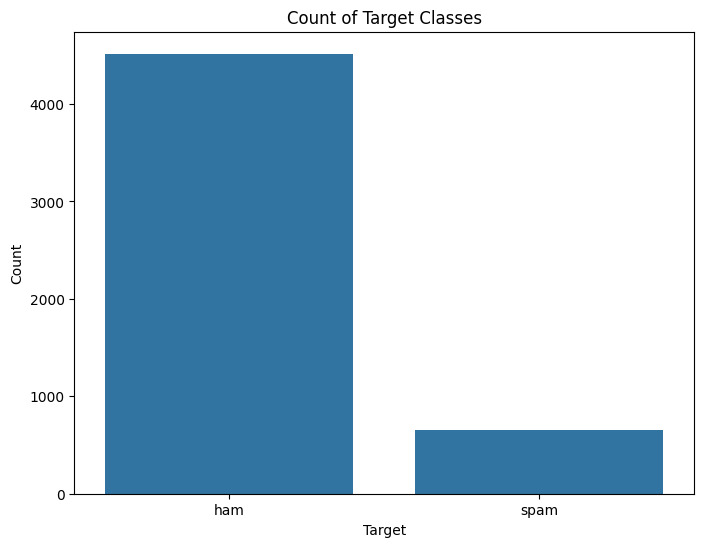

In [15]:
# Vẽ biểu đồ cột đếm số lượng giá trị trong cột target
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=df)

plt.title('Count of Target Classes')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


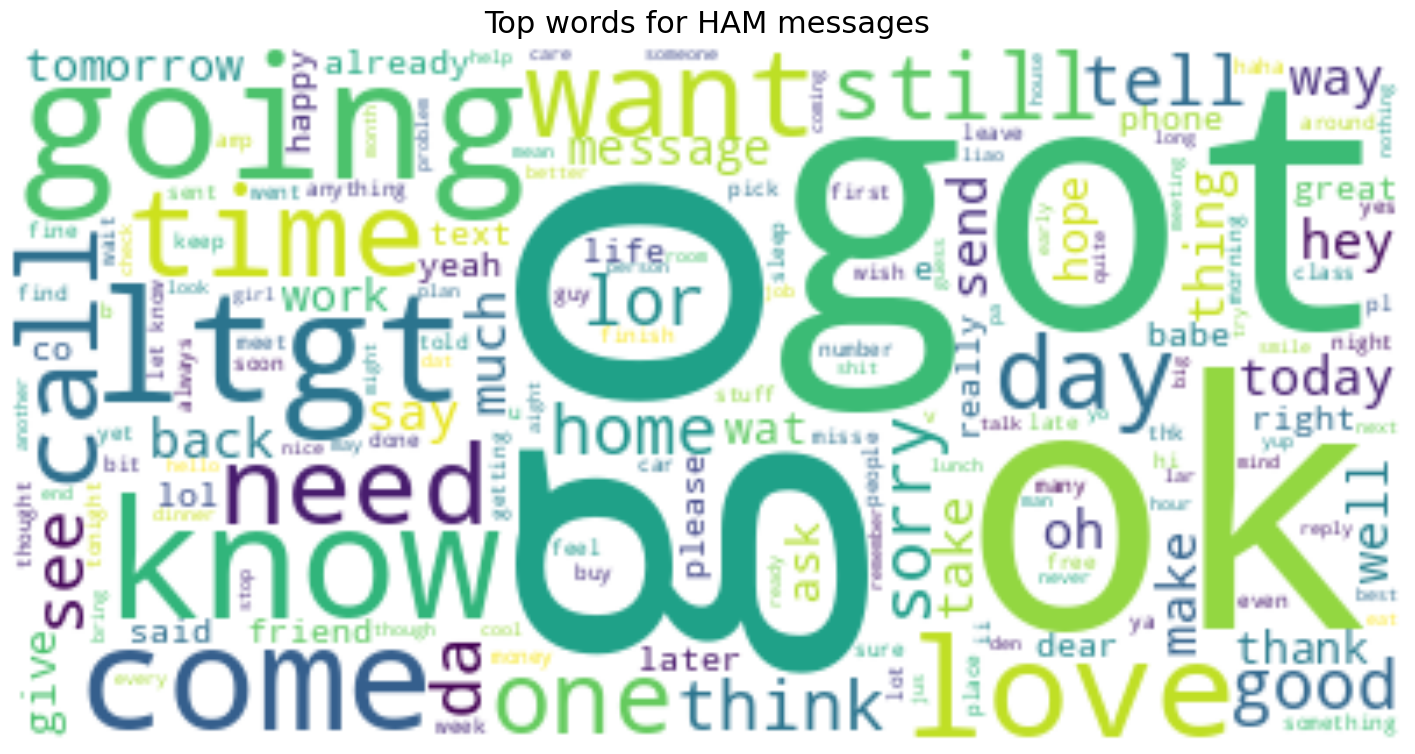

In [16]:
# Filter the DataFrame for 'ham' messages and join them into a single string
ham_messages = ' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean'])

# Create a WordCloud object
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=None,  # No mask is provided in this example
)

# Generate the WordCloud from the 'ham' messages
wc.generate(ham_messages)

# Display the WordCloud
plt.figure(figsize=(18, 10))
plt.title('Top words for HAM messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

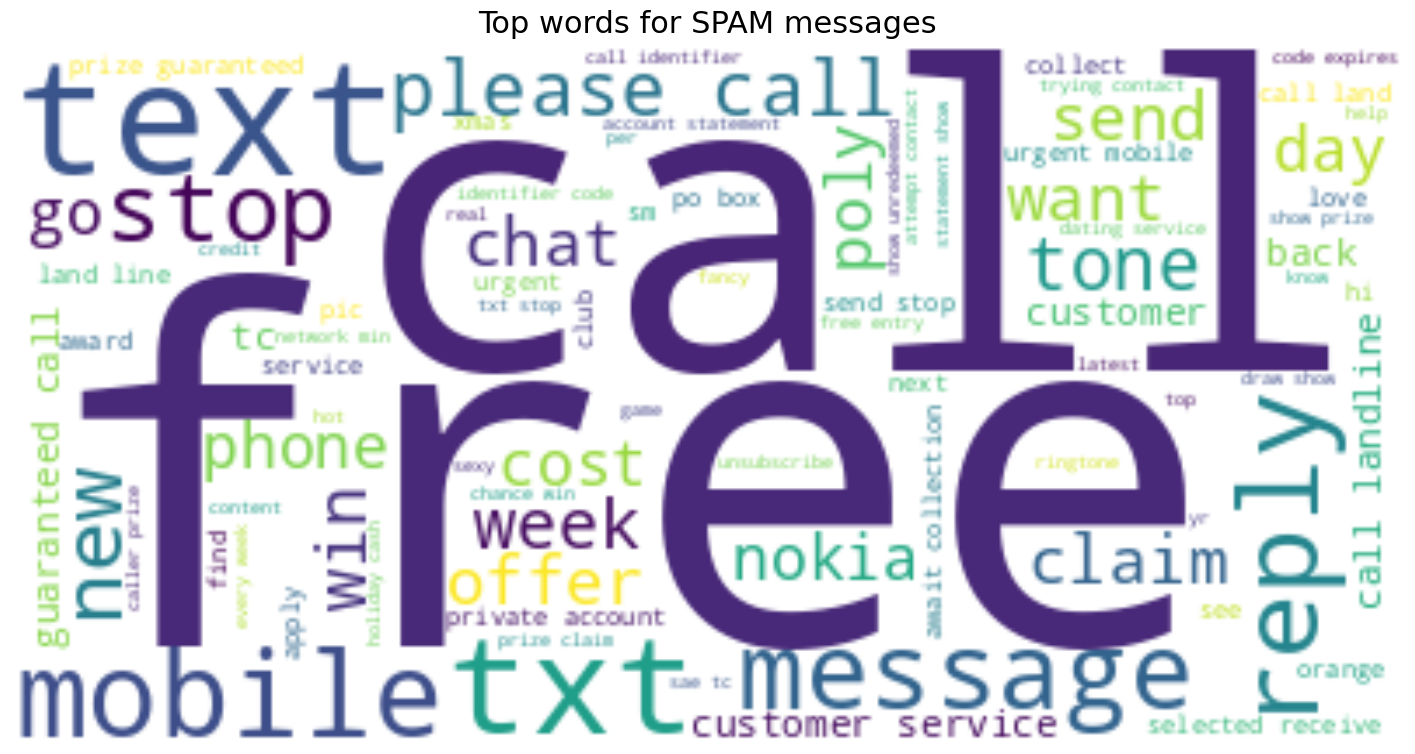

In [17]:
# Filter the DataFrame for 'spam' messages and join them into a single string
spam_messages = ' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean'])

# Create a WordCloud object
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=None,  # No mask is provided in this example
)

# Generate the WordCloud from the 'spam' messages
wc.generate(spam_messages)

# Display the WordCloud
plt.figure(figsize=(18, 10))
plt.title('Top words for SPAM messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


#3. Chuẩn bị dữ liệu cho mô hình

In [18]:
# Chia train, test set
X_train, X_test, y_train, y_test = train_test_split(df['message_clean'],df['target_encoded'], test_size = .2, random_state = 1)

# Sử dụng CountVectorizer để chuyển đổi văn bản thành ma trận đếm
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#4. Mô hình máy học SVM

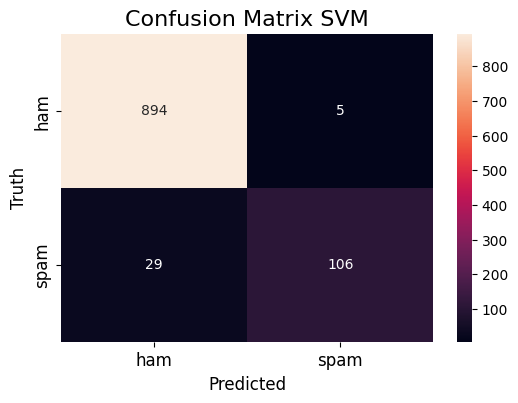

Classification Report SVM:
               precision    recall  f1-score   support

         ham       0.97      0.99      0.98       899
        spam       0.95      0.79      0.86       135

    accuracy                           0.97      1034
   macro avg       0.96      0.89      0.92      1034
weighted avg       0.97      0.97      0.97      1034



In [19]:
svm = SVC(kernel='linear')

start = time.time()

svm.fit(X_train_vectorized, y_train)
y_pred_svm = svm.predict(X_test_vectorized)

end = time.time()

runtime_svm = end - start

# Tính confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
labels = df['target'].unique()

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize = 12)
plt.ylabel('Truth', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Confusion Matrix SVM', fontsize = 16)
plt.show()

# Tính classification report
classification_rep_svm = classification_report(y_test, y_pred_svm, target_names=labels)
print("Classification Report SVM:\n", classification_rep_svm)

#5. Mô hình học sâu LSTM

In [20]:
# Chuyển đổi ma trận thưa thớt thành mảng thường
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Reshape để phù hợp với đầu vào của mô hình LSTM
X_train_reshaped = np.reshape(X_train_dense, (X_train_dense.shape[0], 1, X_train_dense.shape[1]))
X_test_reshaped = np.reshape(X_test_dense, (X_test_dense.shape[0], 1, X_test_dense.shape[1]))

# Xây dựng mô hình LSTM với Dropout
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train_dense.shape[1])))
model.add(Dropout(0.5))  # Thêm dropout với tỷ lệ 0.5 để giúp giảm overfitting
model.add(Dense(1, activation='sigmoid'))

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Bắt đầu đo thời gian
start_time = time.time()

# Huấn luyện mô hình và dự đoán
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))
y_pred_lstm = model.predict(X_test_reshaped)
y_pred_binary = (y_pred_lstm > 0.5).astype(int)

# Kết thúc đo thời gian
end_time = time.time()

# Tính và in thời gian chạy
runtime_lstm = end_time - start_time
print(f"Thời gian chạy mô hình: {runtime_lstm} giây")


Epoch 1/10
130/130 [==============================] - 14s 55ms/step - loss: 0.4908 - accuracy: 0.9146 - val_loss: 0.2840 - val_accuracy: 0.9313
Epoch 2/10
130/130 [==============================] - 5s 41ms/step - loss: 0.1820 - accuracy: 0.9652 - val_loss: 0.1454 - val_accuracy: 0.9623
Epoch 3/10
130/130 [==============================] - 5s 41ms/step - loss: 0.0920 - accuracy: 0.9787 - val_loss: 0.1078 - val_accuracy: 0.9662
Epoch 4/10
130/130 [==============================] - 5s 35ms/step - loss: 0.0620 - accuracy: 0.9838 - val_loss: 0.0933 - val_accuracy: 0.9729
Epoch 5/10
130/130 [==============================] - 4s 27ms/step - loss: 0.0421 - accuracy: 0.9884 - val_loss: 0.0865 - val_accuracy: 0.9729
Epoch 6/10
130/130 [==============================] - 4s 32ms/step - loss: 0.0303 - accuracy: 0.9920 - val_loss: 0.0840 - val_accuracy: 0.9758
Epoch 7/10
130/130 [==============================] - 3s 22ms/step - loss: 0.0216 - accuracy: 0.9952 - val_loss: 0.0837 - val_accuracy: 0.975

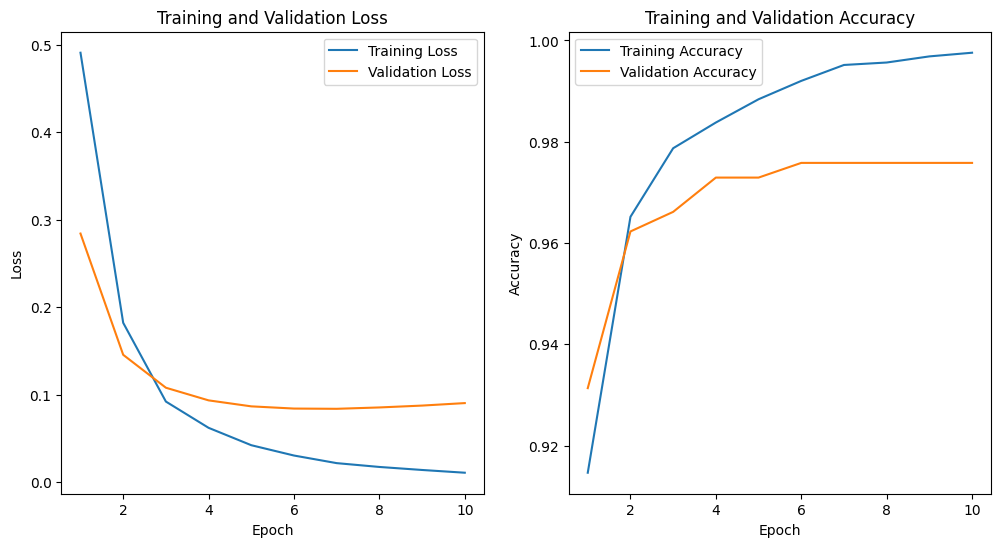

In [21]:
# Lấy các giá trị mất mát và độ chính xác từ lịch sử
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Tạo mảng các epoch
epochs = np.arange(1, 11)

# Vẽ learning curve cho loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ learning curve cho accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


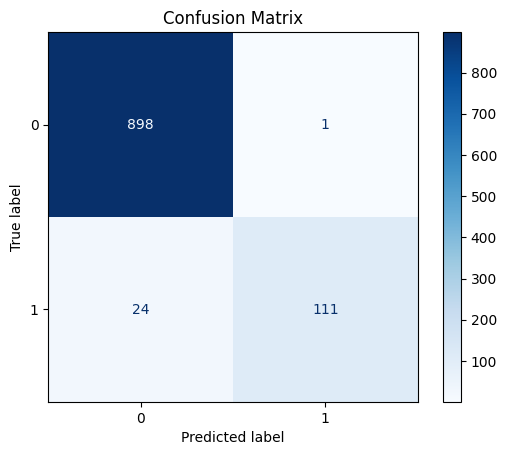

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       899
           1       0.99      0.82      0.90       135

    accuracy                           0.98      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.98      0.98      0.97      1034



In [22]:
# Tính confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_binary)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# In classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

#6. Maxent

Best C:  100
Best score:  0.9714631197097944


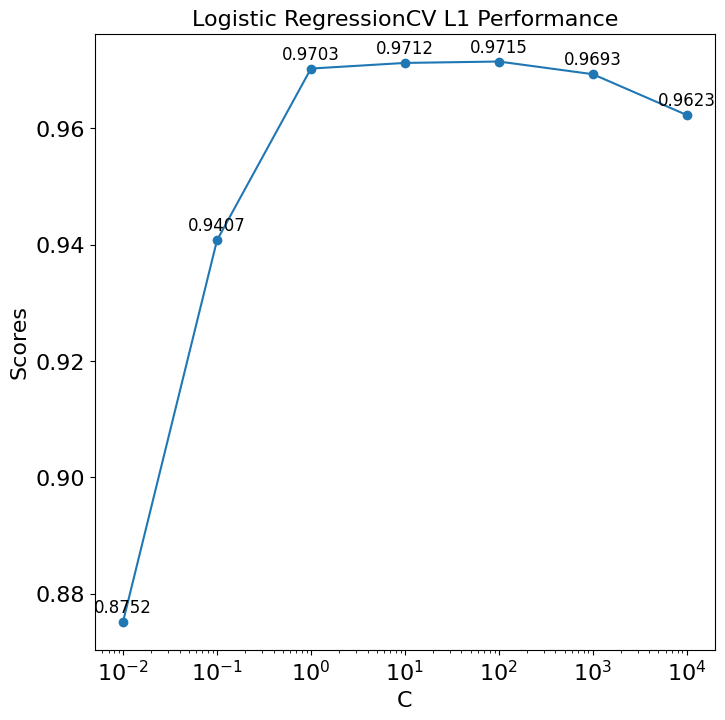

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

Cs = [0.01, 0.1, 1, 10, 100, 1000, 10000]

best_C = None
best_score = 0
scores = []

for C in Cs:
  # Tạo mô hình Logistic RegressionCV với hình phạt L1 regularization và tìm giá trị tốt nhất của C
  model_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear')
  scores_l1 = cross_val_score(model_l1, X_train_vectorized, y_train, cv=5)

  mean_score_l1 = scores_l1.mean()
  scores.append(mean_score_l1)

  if mean_score_l1 > best_score:
    best_score = mean_score_l1
    best_C = C

print("Best C: ", best_C)
print("Best score: ", best_score)

# Vẽ biểu đồ
plt.figure(figsize = (8, 8))
plt.plot(Cs, scores, marker='o')
plt.xscale('log')
plt.xlabel('C',fontsize = 16)
plt.ylabel('Scores',fontsize = 16)
plt.title('Logistic RegressionCV L1 Performance',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for i in range(len(Cs)):
  plt.text(Cs[i], scores[i]+0.001, f'{scores[i]:.4f}', ha='center', va='bottom',fontsize = 12)
plt.show()

Best C:  10
Best score:  0.9767835550181377


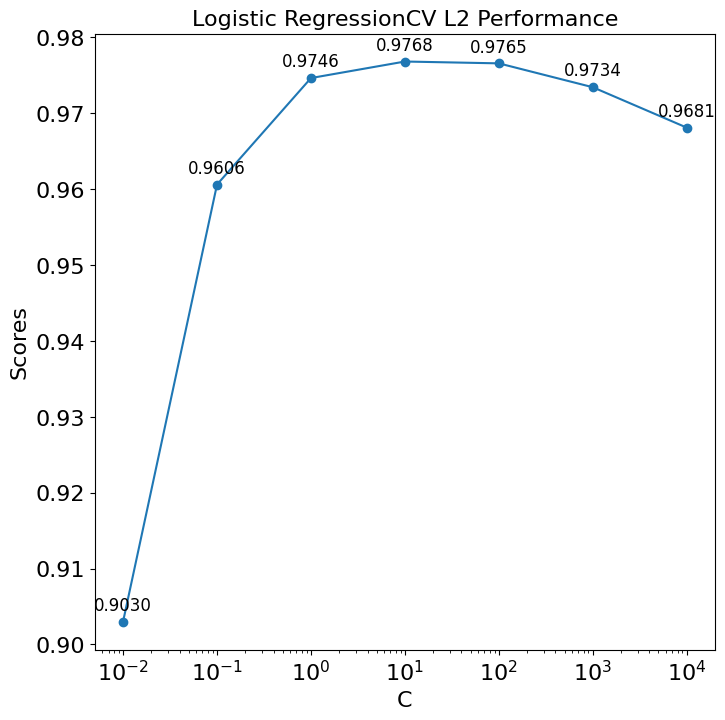

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

Cs = [0.01, 0.1, 1, 10, 100, 1000, 10000]

best_C = None
best_score = 0
scores = []

for C in Cs:
  # Tạo mô hình Logistic RegressionCV với hình phạt L2 regularization và tìm giá trị tốt nhất của C
  model_l2 = LogisticRegression(penalty='l2', C=C, solver='liblinear')
  scores_l2 = cross_val_score(model_l2, X_train_vectorized, y_train, cv=5)  # Thực hiện cross-validation

  mean_score_l2 = scores_l2.mean()
  scores.append(mean_score_l2)

  if mean_score_l2 > best_score:
    best_score = mean_score_l2
    best_C = C

print("Best C: ", best_C)
print("Best score: ", best_score)

# Vẽ biểu đồ
plt.figure(figsize = (8, 8))
plt.plot(Cs, scores, marker='o')
plt.xscale('log')
plt.xlabel('C',fontsize = 16)
plt.ylabel('Scores',fontsize = 16)
plt.title('Logistic RegressionCV L2 Performance',fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for i in range(len(Cs)):
  plt.text(Cs[i], scores[i]+0.001, f'{scores[i]:.4f}', ha='center', va='bottom',fontsize = 12)
plt.show()

In [25]:
L1 = LogisticRegression(penalty='l1', C=100, solver='liblinear')
L1.fit(X_train_vectorized, y_train)
y_pred_L1 = L1.predict(X_test_vectorized)

L2 = LogisticRegression(penalty='l2', C=10, solver='liblinear')
L2.fit(X_train_vectorized, y_train)
y_pred_L2 = L2.predict(X_test_vectorized)

print('------Điểm số của mô hình theo phương pháp L1------')
print(classification_report(y_test, y_pred_L1))
print('-'*60)
print('------Điểm số của mô hình theo phương pháp L2------')
print(classification_report(y_test, y_pred_L2))

------Điểm số của mô hình theo phương pháp L1------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       899
           1       0.93      0.81      0.87       135

    accuracy                           0.97      1034
   macro avg       0.95      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034

------------------------------------------------------------
------Điểm số của mô hình theo phương pháp L2------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       899
           1       0.97      0.81      0.88       135

    accuracy                           0.97      1034
   macro avg       0.97      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



In [26]:
maxent = LogisticRegression(penalty='l2', C=10, solver='liblinear')

start = time.time()

maxent.fit(X_train_vectorized, y_train)
y_pred_maxent = maxent.predict(X_test_vectorized)

end = time.time()

runtime_maxent = end - start

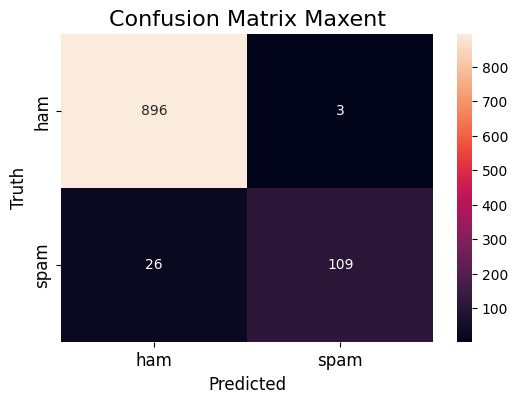

In [27]:
cm_maxent = confusion_matrix(y_test, y_pred_maxent)
labels = df['target'].unique()

plt.figure(figsize=(6,4))
sns.heatmap(cm_maxent, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize = 12)
plt.ylabel('Truth', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Confusion Matrix Maxent', fontsize = 16)
plt.show()

In [28]:
print(classification_report(y_test, y_pred_maxent))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       899
           1       0.97      0.81      0.88       135

    accuracy                           0.97      1034
   macro avg       0.97      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



#7. Đánh giá mô hình

## Các chỉ số

In [29]:
def classification_eval(y_test, y_pred):
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [30]:
scores_svm = classification_eval(y_test, y_pred_svm)
scores_lstm = classification_eval(y_test, y_pred_binary)
scores_maxent = classification_eval(y_test, y_pred_maxent)

df_scores = pd.DataFrame({
    'Model': ['SVM', 'MaxEnt','LSTM'],
    'Accuracy': [scores_svm[0], scores_maxent[0],scores_lstm[0]],
    'Precision': [scores_svm[1], scores_maxent[1],scores_lstm[1]],
    'Recall': [scores_svm[2], scores_maxent[2],scores_lstm[2]],
    'F1 Score': [scores_svm[3], scores_maxent[3],scores_lstm[3]],
    'Runtime (second)' : [runtime_svm, runtime_maxent, runtime_lstm]
})

df_scores

,Model,Accuracy,Precision,Recall,F1 Score,Runtime (second)
0,SVM,0.967118,0.954955,0.785185,0.861789,0.495167
1,MaxEnt,0.971954,0.973214,0.807407,0.882591,0.023722
2,LSTM,0.975822,0.991071,0.822222,0.898785,51.020655


## Confusion matrix

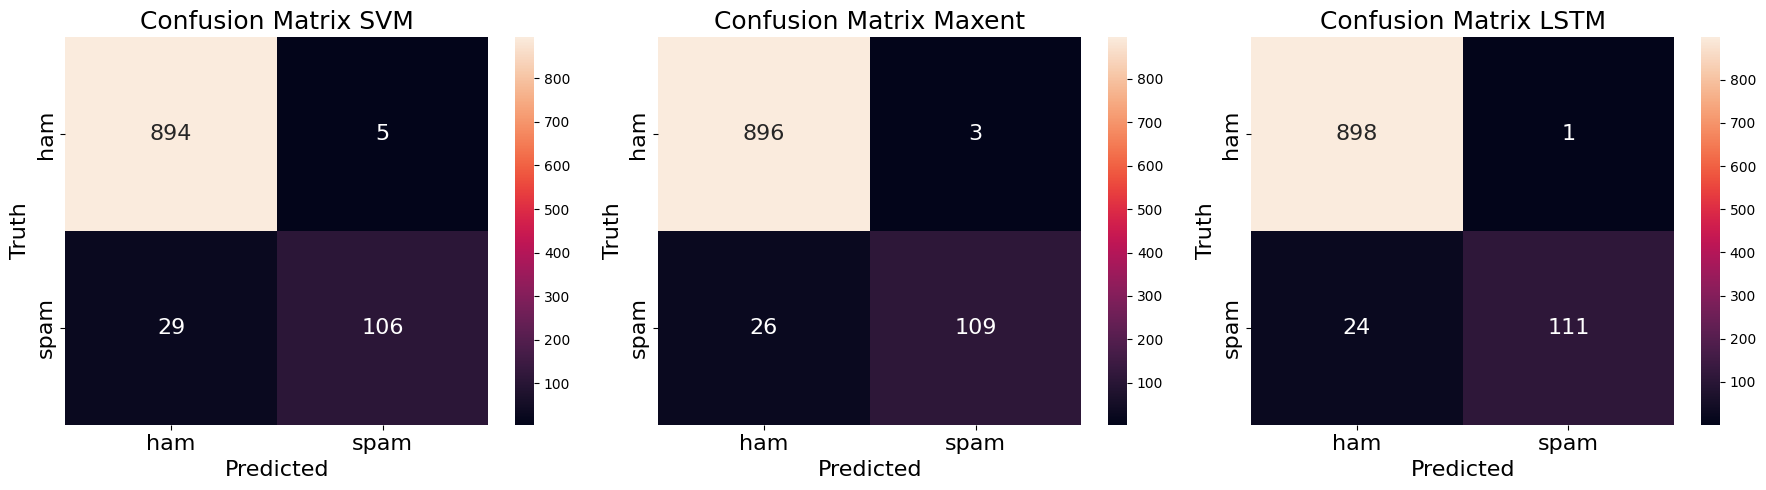

In [31]:
cm = [cm_svm, cm_maxent, cm_lstm]
model_names = ['SVM', 'Maxent', 'LSTM']
labels = df['target'].unique()

plt.figure(figsize=(18, 5))

for i, (c, model_name) in enumerate(zip(cm, model_names), start=1):
    plt.subplot(1, 3, i)
    sns.heatmap(c, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Truth', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f'Confusion Matrix {model_name}', fontsize=18)

plt.tight_layout()
plt.show()